In [1]:
%pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=33f1bd674ab5df7c7c5243421c4994484f47396d8ddf86977f404f57d6e89f26
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
%pip install prophet

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import ta
from prophet import Prophet # Import Prophet
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import logging
import warnings
from sklearn.exceptions import DataConversionWarning

# Tắt bớt logging từ Prophet
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)

In [4]:
# Đọc dữ liệu
df_lsg = pd.read_csv('fpt_lsg.csv')
df_kn = pd.read_csv('fpt_kn.csv')

# Chuyển đổi cột Ngày sang datetime
df_lsg['Ngày'] = pd.to_datetime(df_lsg['Ngày'], format='%Y-%m-%d')
df_kn['Ngày'] = pd.to_datetime(df_kn['Ngày'], format='%Y-%m-%d')

# Sắp xếp dữ liệu theo ngày và reset index
df_lsg = df_lsg.sort_values('Ngày').reset_index(drop=True)
df_kn = df_kn.sort_values('Ngày').reset_index(drop=True)

# Đổi tên cột và chọn các cột cần thiết cho df_lsg
df_lsg = df_lsg.rename(columns={
    'Ngày': 'Date', 'Giá đóng cửa': 'Close', 'Giá mở cửa': 'Open',
    'Giá cao nhất': 'High', 'Giá thấp nhất': 'Low', 'KL gd khớp lệnh': 'Volume'
})
df_lsg = df_lsg[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Đổi tên cột và chọn các cột cần thiết cho df_kn
df_kn = df_kn.rename(columns={
    'Ngày': 'Date', 'KL giao dịch ròng': 'NetForeignVolume', 'GT giao dịch ròng': 'NetForeignValue'
})
df_kn = df_kn[['Date', 'NetForeignVolume', 'NetForeignValue']]

# Chuyển đổi các cột số trong df_kn sang float, loại bỏ dấu phẩy
for col in ['NetForeignVolume', 'NetForeignValue']:
    if df_kn[col].dtype == 'object':
        df_kn[col] = df_kn[col].str.replace(',', '', regex=False).astype(float)

# Gộp hai DataFrame
df_merged = pd.merge(df_lsg, df_kn, on='Date', how='inner')
df_merged

,Date,Open,High,Low,Close,Volume,NetForeignVolume,NetForeignValue
0,2006-12-13,400.0,400.0,400.0,400.0,83530,1240,0.00
1,2006-12-14,420.0,420.0,420.0,420.0,280710,178460,0.07
2,2006-12-15,441.0,441.0,441.0,441.0,265300,1650,0.00
3,2006-12-18,463.0,463.0,463.0,463.0,215790,123310,0.06
4,2006-12-19,486.0,486.0,486.0,486.0,137520,46450,0.02
...,...,...,...,...,...,...,...,...
4531,2025-04-29,109.6,110.5,109.1,109.4,2945500,-401800,-44.02
4532,2025-05-05,109.5,109.7,106.9,108.6,7167600,2391269,-230.69
4533,2025-05-06,108.6,111.0,108.6,109.7,5686200,318700,34.96
4534,2025-05-07,109.6,111.2,108.9,109.7,3926800,-212400,-23.14


In [5]:
#Hàm tính toán chỉ báo kỹ thuật
def add_technical_indicators(df):
    df_ti = df.copy()
    df_ti['SMA_20'] = ta.trend.SMAIndicator(close=df_ti['Close'], window=20, fillna=True).sma_indicator()
    df_ti['EMA_20'] = ta.trend.EMAIndicator(close=df_ti['Close'], window=20, fillna=True).ema_indicator()
    macd_indicator = ta.trend.MACD(close=df_ti['Close'], window_slow=26, window_fast=12, window_sign=9, fillna=True)
    df_ti['MACD'] = macd_indicator.macd()
    df_ti['MACD_signal'] = macd_indicator.macd_signal()
    df_ti['MACD_hist'] = macd_indicator.macd_diff()
    df_ti['RSI_14'] = ta.momentum.RSIIndicator(close=df_ti['Close'], window=14, fillna=True).rsi()
    return df_ti

df_features_initial = add_technical_indicators(df_merged.copy())
df_all_raw = df_features_initial.dropna().reset_index(drop=True)
df_all_raw

,Date,Open,High,Low,Close,Volume,NetForeignVolume,NetForeignValue,SMA_20,EMA_20,MACD,MACD_signal,MACD_hist,RSI_14
0,2006-12-13,400.0,400.0,400.0,400.0,83530,1240,0.00,400.000000,400.000000,0.000000,0.000000,0.000000,100.000000
1,2006-12-14,420.0,420.0,420.0,420.0,280710,178460,0.07,410.000000,401.904762,1.595442,0.319088,1.276353,100.000000
2,2006-12-15,441.0,441.0,441.0,441.0,265300,1650,0.00,420.333333,405.628118,4.502463,1.155763,3.346700,100.000000
3,2006-12-18,463.0,463.0,463.0,463.0,215790,123310,0.06,431.000000,411.092107,8.483720,2.621355,5.862366,100.000000
4,2006-12-19,486.0,486.0,486.0,486.0,137520,46450,0.02,442.000000,418.226192,13.341016,4.765287,8.575729,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4531,2025-04-29,109.6,110.5,109.1,109.4,2945500,-401800,-44.02,112.485000,114.098915,-4.387536,-5.034871,0.647335,37.494194
4532,2025-05-05,109.5,109.7,106.9,108.6,7167600,2391269,-230.69,111.890000,113.575208,-4.312141,-4.890325,0.578184,36.459702
4533,2025-05-06,108.6,111.0,108.6,109.7,5686200,318700,34.96,111.275000,113.206141,-4.116181,-4.735496,0.619316,38.953775
4534,2025-05-07,109.6,111.2,108.9,109.7,3926800,-212400,-23.14,111.085000,112.872223,-3.915742,-4.571545,0.655803,38.953775


In [6]:
# lọc dữ liệu 5 năm gần nhất
end_date_of_data = pd.to_datetime('2025-05-08')
start_date_5_years = end_date_of_data - pd.DateOffset(years=5)
df_all = df_all_raw[df_all_raw['Date'] >= start_date_5_years].reset_index(drop=True)

ti_cols_to_drop = ['SMA_20', 'EMA_20', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI_14']
df_all = add_technical_indicators(df_all.drop(columns=ti_cols_to_drop, errors='ignore'))
df_all = df_all.dropna().reset_index(drop=True)
df_all

,Date,Open,High,Low,Close,Volume,NetForeignVolume,NetForeignValue,SMA_20,EMA_20,MACD,MACD_signal,MACD_hist,RSI_14
0,2020-05-08,53.60,55.10,53.6,53.70,3585320,8280,0.44,53.700000,53.700000,0.000000,0.000000,0.000000,100.000000
1,2020-05-11,54.00,54.40,53.3,54.00,2119430,-3430,-0.08,53.850000,53.728571,0.023932,0.004786,0.019145,100.000000
2,2020-05-12,54.00,54.40,53.6,54.40,2828190,0,0.00,54.033333,53.792517,0.074318,0.018693,0.055625,100.000000
3,2020-05-13,47.50,49.55,47.4,49.35,6853810,1870,0.09,52.862500,53.369420,-0.289902,-0.043026,-0.246876,11.093147
4,2020-05-14,48.95,49.10,48.5,48.70,2597400,-200,-0.01,52.030000,52.924713,-0.623808,-0.159183,-0.464625,9.876050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,2025-04-29,109.60,110.50,109.1,109.40,2945500,-401800,-44.02,112.485000,114.098915,-4.387536,-5.034871,0.647335,37.494194
1235,2025-05-05,109.50,109.70,106.9,108.60,7167600,2391269,-230.69,111.890000,113.575208,-4.312141,-4.890325,0.578184,36.459702
1236,2025-05-06,108.60,111.00,108.6,109.70,5686200,318700,34.96,111.275000,113.206141,-4.116181,-4.735496,0.619316,38.953775
1237,2025-05-07,109.60,111.20,108.9,109.70,3926800,-212400,-23.14,111.085000,112.872223,-3.915742,-4.571545,0.655803,38.953775


In [7]:
#Huấn luyện Prophet Models để dự đoán các đặc trưng trong tương lai
prophet_models = {}
prophet_features_to_predict = ['Open', 'High', 'Low', 'Volume']
regressor_name_prophet = 'prev_close' # Tên của regressor

if not df_all.empty:
    df_all_original_unscaled_for_prophet = df_all.copy()
    # Tạo feature 'prev_close'
    df_all_original_unscaled_for_prophet[regressor_name_prophet] = df_all_original_unscaled_for_prophet['Close'].shift(1)
    # Dòng đầu tiên sẽ có NaN cho prev_close, Prophet sẽ bỏ qua nó khi fit nếu regressor có NaN

    print("\n--- Training Prophet Models with 'prev_close' regressor ---")
    for feature_name in prophet_features_to_predict:
        print(f"Training Prophet model for {feature_name}...")
        # Chọn cột cần thiết và đổi tên cho Prophet
        prophet_df_train = df_all_original_unscaled_for_prophet[['Date', feature_name, regressor_name_prophet]].rename(
            columns={'Date': 'ds', feature_name: 'y'}
        )
        # Loại bỏ các dòng có NaN ở 'y' hoặc regressor trước khi fit
        prophet_df_train = prophet_df_train.dropna(subset=['y', regressor_name_prophet])

        if len(prophet_df_train) < 2:
            print(f"Not enough data after dropna to train Prophet for {feature_name}. Skipping.")
            prophet_models[feature_name] = None
            continue

        model_p = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
        model_p.add_regressor(regressor_name_prophet) # Thêm regressor
        # model_p.add_country_holidays(country_name='VN') # Tùy chọn
        model_p.fit(prophet_df_train)
        prophet_models[feature_name] = model_p
    print("--- Prophet Models Training Finished ---")
else:
    print("df_all is empty. Skipping Prophet model training.")



--- Training Prophet Models with 'prev_close' regressor ---
Training Prophet model for Open...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp92d9x7fy/7ugiuo8e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp92d9x7fy/aan_8rjx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57600', 'data', 'file=/tmp/tmp92d9x7fy/7ugiuo8e.json', 'init=/tmp/tmp92d9x7fy/aan_8rjx.json', 'output', 'file=/tmp/tmp92d9x7fy/prophet_modelplhibyno/prophet_model-20250517084219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp92d9x7fy/3bo62mgu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp92d9x7fy/ry_p4yhq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Training Prophet model for High...


08:42:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp92d9x7fy/qq5shivo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp92d9x7fy/7wbyveqc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87921', 'data', 'file=/tmp/tmp92d9x7fy/qq5shivo.json', 'init=/tmp/tmp92d9x7fy/7wbyveqc.json', 'output', 'file=/tmp/tmp92d9x7fy/prophet_model8wjulhze/prophet_model-20250517084220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet model for Low...


08:42:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp92d9x7fy/3u1e7s8g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp92d9x7fy/54v80mx5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61029', 'data', 'file=/tmp/tmp92d9x7fy/3u1e7s8g.json', 'init=/tmp/tmp92d9x7fy/54v80mx5.json', 'output', 'file=/tmp/tmp92d9x7fy/prophet_modeld5l1fd57/prophet_model-20250517084221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet model for Volume...


08:42:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Prophet Models Training Finished ---


In [8]:
# --- Chuẩn bị đặc trưng và Scaling cho LSTM-Informer ---
features_lstm = ['Open', 'High', 'Low', 'Close', 'Volume',
                 'NetForeignVolume', 'NetForeignValue',
                 'SMA_20', 'EMA_20', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI_14']
target_col_lstm = 'Close'


df_all_original_unscaled_for_lstm = df_all.copy()

In [9]:
# --- Tạo Dataset và DataLoader cho LSTM-Informer ---
sequence_length = 7

class StockDataset(Dataset):
    def __init__(self, df_data, features_list, target_column, seq_len):
        self.X = []
        self.y = []
        for i in range(len(df_data) - seq_len):
            seq_x = df_data[features_list].iloc[i:i+seq_len].values
            seq_y = df_data[target_column].iloc[i+seq_len]
            self.X.append(seq_x)
            self.y.append(seq_y)
        self.X = np.array(self.X)
        self.y = np.array(self.y)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

train_size = int(len(df_all) * 0.85)

df_train = df_all.iloc[:train_size].copy()
df_val   = df_all.iloc[train_size:].copy()

# Scale chỉ fit trên train, rồi transform lên val
scaler_lstm = MinMaxScaler()
df_train.loc[:, features_lstm] = scaler_lstm.fit_transform(df_train[features_lstm])
df_val.loc[:,   features_lstm] = scaler_lstm.transform(df_val[features_lstm])

# Tạo Dataset và DataLoader chỉ với 2 tập
train_ds = StockDataset(df_train, features_lstm, target_col_lstm, sequence_length)
val_ds   = StockDataset(df_val,   features_lstm, target_col_lstm, sequence_length)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

<ipython-input-9-7dd6d2fe1f02>:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.2494713  0.14077252 0.19332854 ... 0.29146955 0.17369381 0.27659464]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[:, features_lstm] = scaler_lstm.fit_transform(df_train[features_lstm])
<ipython-input-9-7dd6d2fe1f02>:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.60383951 0.60241581 0.60283283 ... 0.52782979 0.62680851 0.64643161]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[:, features_lstm] = scaler_lstm.fit_transform(df_train[features_lstm])
<ipython-input-9-7dd6d2fe1f02>:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.34397663 0.15963458 0.19636951 0.49305937 0.72

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")



Using device: cuda


In [11]:
# --- Định nghĩa Model LSTM-Informer ---
class LSTMInformerHybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden, transformer_heads):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden, batch_first=True)
        self.lstm_fc = nn.Linear(lstm_hidden, 32)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim, nhead=transformer_heads,
            dim_feedforward=64, dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.trans_fc = nn.Linear(input_dim, 32)
        self.final_fc = nn.Linear(64, 1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        lstm_out = self.lstm_fc(lstm_out)
        trans_out = self.transformer(x)
        trans_out = trans_out.mean(dim=1)
        trans_out = self.trans_fc(trans_out)
        combined = torch.cat([lstm_out, trans_out], dim=1)
        out = self.final_fc(combined)
        return out.squeeze(-1)


input_dim_lstm = len(features_lstm)
model_lstm = LSTMInformerHybrid(input_dim=input_dim_lstm, lstm_hidden=64, transformer_heads=1).to(device)
print("\nLSTM-Informer Model ready.")
print(model_lstm)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



LSTM-Informer Model ready.
LSTMInformerHybrid(
  (lstm): LSTM(13, 64, batch_first=True)
  (lstm_fc): Linear(in_features=64, out_features=32, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=13, out_features=13, bias=True)
        )
        (linear1): Linear(in_features=13, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=13, bias=True)
        (norm1): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (trans_fc): Linear(in_features=13, out_features=32, bias=True)
  (final_fc): Linear(in_features=64, out_features=1, bias=True)
)



--- Starting LSTM-Informer Training ---
Epoch 1/100 | Train Loss: 0.070661 | Val Loss: 0.373818
  ↳ Saved best LSTM-Informer model.
Epoch 2/100 | Train Loss: 0.035608 | Val Loss: 0.235748
  ↳ Saved best LSTM-Informer model.
Epoch 3/100 | Train Loss: 0.022418 | Val Loss: 0.162156
  ↳ Saved best LSTM-Informer model.
Epoch 4/100 | Train Loss: 0.016618 | Val Loss: 0.126717
  ↳ Saved best LSTM-Informer model.
Epoch 5/100 | Train Loss: 0.012119 | Val Loss: 0.102555
  ↳ Saved best LSTM-Informer model.
Epoch 6/100 | Train Loss: 0.008950 | Val Loss: 0.075899
  ↳ Saved best LSTM-Informer model.
Epoch 7/100 | Train Loss: 0.006207 | Val Loss: 0.056314
  ↳ Saved best LSTM-Informer model.
Epoch 8/100 | Train Loss: 0.004667 | Val Loss: 0.040767
  ↳ Saved best LSTM-Informer model.
Epoch 9/100 | Train Loss: 0.003886 | Val Loss: 0.029327
  ↳ Saved best LSTM-Informer model.
Epoch 10/100 | Train Loss: 0.003158 | Val Loss: 0.022953
  ↳ Saved best LSTM-Informer model.
Epoch 11/100 | Train Loss: 0.002893 | 

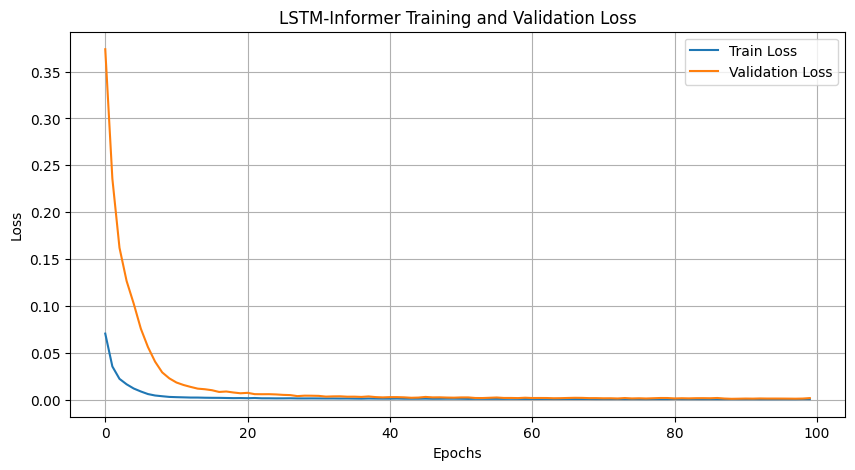

In [12]:
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
best_val_loss = float('inf')
train_losses = []
val_losses = []
epochs = 100

print("\n--- Starting LSTM-Informer Training ---")
for epoch in range(1, epochs + 1):
    model_lstm.train()
    epoch_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model_lstm(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    epoch_train_loss /= max(1, len(train_loader))
    train_losses.append(epoch_train_loss)

    model_lstm.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model_lstm(xb)
            loss = loss_fn(preds, yb)
            epoch_val_loss += loss.item()
    epoch_val_loss /= max(1, len(val_loader))
    val_losses.append(epoch_val_loss)
    print(f"Epoch {epoch}/{epochs} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model_lstm.state_dict(), "best_model_lstm_5years_prophet_regressor.pth")
        print("  ↳ Saved best LSTM-Informer model.")
print("--- LSTM-Informer Training Finished ---")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('LSTM-Informer Training and Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.show()


--- Predicting next 765 days using LSTM-Informer and Prophet with regressor ---

Future predictions (OHLCV):
          Date        Open        High         Low       Close        Volume
0   2025-05-09  114.231846  116.383333  108.474392  108.474392  6.252245e+06
1   2025-05-12  108.582494  110.530278  107.103939  108.351342  6.040729e+06
2   2025-05-13  108.446769  110.601196  107.177531  107.753128  6.115597e+06
3   2025-05-14  107.750651  109.972315  106.569974  107.084725  6.178261e+06
4   2025-05-15  107.282602  109.565403  106.122224  107.356498  6.210899e+06
..         ...         ...         ...         ...         ...           ...
760 2028-04-07   78.347079   81.097327   76.528412   80.839531  1.431296e+07
761 2028-04-10   80.152169   82.677067   77.940412   82.500076  1.425982e+07
762 2028-04-11   81.771749   84.498657   79.680159   84.046345  1.435985e+07
763 2028-04-12   83.188412   85.975072   81.093495   85.522315  1.443754e+07
764 2028-04-13   84.833801   87.673717   82

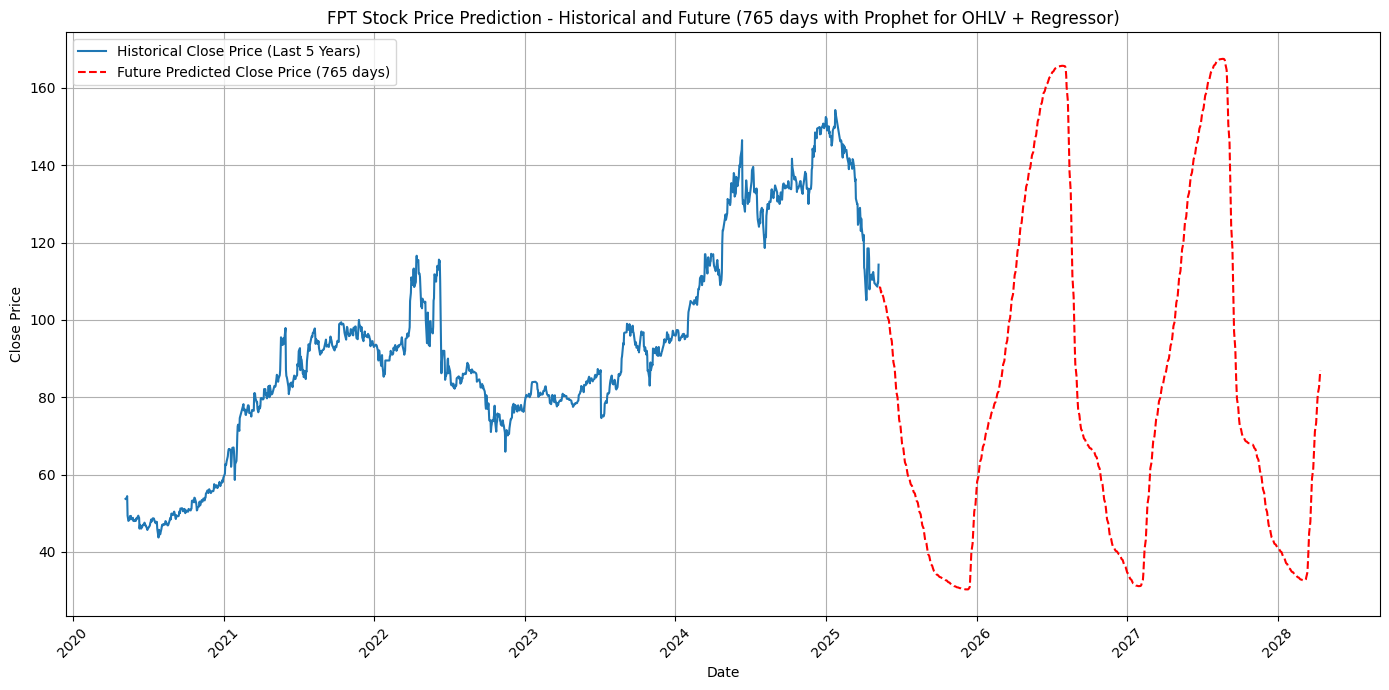

In [13]:
N_future_days = 765
print(f"\n--- Predicting next {N_future_days} days using LSTM-Informer and Prophet with regressor ---")

history_df_unscaled = df_all_original_unscaled_for_lstm.copy()
# Đảm bảo history_df_unscaled có cột 'prev_close' cho lần dự đoán Prophet đầu tiên
if regressor_name_prophet not in history_df_unscaled.columns:
    history_df_unscaled[regressor_name_prophet] = history_df_unscaled['Close'].shift(1)
    # Dòng đầu tiên sẽ là NaN, không sao vì Prophet chỉ dùng các dòng sau

future_predictions_rescaled_list = [] # Lưu trữ giá Close dự đoán
future_ohlcv_predictions = [] # Lưu trữ dict OHLVC cho từng ngày tương lai

last_date_in_history = history_df_unscaled['Date'].max()
future_business_dates = pd.bdate_range(start=last_date_in_history + pd.Timedelta(days=1), periods=N_future_days)

for i in range(N_future_days):
    # 1. Lấy sequence_length ngày cuối cùng từ history_df_unscaled cho LSTM-Informer
    current_input_sequence_unscaled_df = history_df_unscaled[features_lstm].iloc[-sequence_length:]

    # 2. Scale_transform các features này bằng scaler_lstm
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning) # Hoặc DataConversionWarning
        current_input_sequence_scaled = scaler_lstm.transform(current_input_sequence_unscaled_df.values)

    # 3. Dự đoán Close bằng LSTM-Informer
    input_tensor = torch.tensor(current_input_sequence_scaled, dtype=torch.float32).unsqueeze(0).to(device)
    model_lstm.eval()
    with torch.no_grad():
        predicted_close_lstm_scaled = model_lstm(input_tensor).item()

    dummy_pred_array = np.zeros((1, len(features_lstm)))
    close_col_idx = features_lstm.index(target_col_lstm)
    dummy_pred_array[0, close_col_idx] = predicted_close_lstm_scaled
    predicted_close_lstm_rescaled = scaler_lstm.inverse_transform(dummy_pred_array)[0, close_col_idx]

    future_predictions_rescaled_list.append(predicted_close_lstm_rescaled)

    # 4. Xác định ngày tiếp theo
    next_day_date = future_business_dates[i]

    # 5. Dự đoán Open, High, Low, Volume bằng Prophet
    # Giá trị regressor cho ngày dự đoán Prophet sẽ là giá Close của ngày lịch sử cuối cùng
    # HOẶC, nếu i > 0, là giá Close dự đoán của LSTM từ ngày i-1
    if i == 0:
        prev_close_for_prophet_pred = history_df_unscaled['Close'].iloc[-1]
    else:
        prev_close_for_prophet_pred = future_predictions_rescaled_list[i-1]

    prophet_preds_values = {}
    future_df_prophet_input = pd.DataFrame({
        'ds': [next_day_date],
        regressor_name_prophet: [prev_close_for_prophet_pred] # Cung cấp giá trị regressor
    })

    for feature_name, model_p_instance in prophet_models.items():
        if model_p_instance:
            forecast = model_p_instance.predict(future_df_prophet_input)
            prophet_preds_values[feature_name] = forecast['yhat'].iloc[0]
        else:
            prophet_preds_values[feature_name] = history_df_unscaled[feature_name].iloc[-1]

    # 6. Áp dụng logic ràng buộc O-H-L-C và Volume
    final_close = predicted_close_lstm_rescaled
    final_open = prophet_preds_values.get('Open', final_close)
    pred_low_p = prophet_preds_values.get('Low', final_close)
    pred_high_p = prophet_preds_values.get('High', final_close)

    final_low = min(pred_low_p, final_open, final_close)
    final_high = max(pred_high_p, final_open, final_close)
    final_open = max(final_low, min(final_open, final_high))

    final_volume = prophet_preds_values.get('Volume', history_df_unscaled['Volume'].iloc[-1])
    final_volume = max(0, final_volume)

    # Lưu trữ các giá trị OHLVC dự đoán
    current_day_ohlcv_preds = {
        'Date': next_day_date, 'Open': final_open, 'High': final_high,
        'Low': final_low, 'Close': final_close, 'Volume': final_volume
    }
    future_ohlcv_predictions.append(current_day_ohlcv_preds)

    # 7. Tạo dòng dữ liệu mới (chưa scale) để cập nhật history cho LSTM
    new_day_data_original_dict = current_day_ohlcv_preds.copy()

    last_hist_day_for_netforeign = history_df_unscaled.iloc[-1]
    new_day_data_original_dict['NetForeignVolume'] = last_hist_day_for_netforeign['NetForeignVolume']
    new_day_data_original_dict['NetForeignValue'] = last_hist_day_for_netforeign['NetForeignValue']

    for col_ti in ti_cols_to_drop: # Sử dụng lại ti_cols_to_drop
        new_day_data_original_dict[col_ti] = np.nan

    new_day_df_unscaled = pd.DataFrame([new_day_data_original_dict])

    # 8. Nối dòng mới và tính lại chỉ báo kỹ thuật
    temp_history_for_ti = pd.concat([history_df_unscaled, new_day_df_unscaled], ignore_index=True)
    # Xóa các cột TI cũ trước khi gọi add_technical_indicators để đảm bảo tính toán lại đúng
    temp_history_with_new_ti = add_technical_indicators(temp_history_for_ti.drop(columns=ti_cols_to_drop, errors='ignore'))

    # 9. Cập nhật history_df_unscaled (bao gồm cả 'prev_close' mới cho lần lặp Prophet tiếp theo)
    history_df_unscaled = temp_history_with_new_ti.copy()
    if regressor_name_prophet not in history_df_unscaled.columns: # Double check
          history_df_unscaled[regressor_name_prophet] = history_df_unscaled['Close'].shift(1)
    else: # Update the last row of prev_close if already exists
          history_df_unscaled.loc[history_df_unscaled.index[-1], regressor_name_prophet] = history_df_unscaled['Close'].iloc[-2] if len(history_df_unscaled) > 1 else np.nan


print("\nFuture predictions (OHLCV):")
df_future_predictions = pd.DataFrame(future_ohlcv_predictions)
print(df_future_predictions)

# Vẽ đồ thị
plt.figure(figsize=(14, 7))
plot_history_df = df_all_original_unscaled_for_lstm
plt.plot(plot_history_df['Date'], plot_history_df[target_col_lstm], label='Historical Close Price (Last 5 Years)')
plt.plot(df_future_predictions['Date'], df_future_predictions['Close'], label=f'Future Predicted Close Price ({N_future_days} days)', linestyle='--', color='red')
plt.title(f'FPT Stock Price Prediction - Historical and Future ({N_future_days} days with Prophet for OHLV + Regressor)')
plt.xlabel('Date'); plt.ylabel('Close Price'); plt.legend(); plt.grid(True); plt.xticks(rotation=45); plt.tight_layout(); plt.show()



--- LSTM-Informer Multi-step Forecasting Evaluation on Test/Validation Set (186 days) ---

--- LSTM-Informer Multi-step Forecasting Evaluation (on Test/Validation set) ---
MAE (multi-step): 75.9473
RMSE (multi-step): 83.1438
R2 Score (multi-step): -52.5790


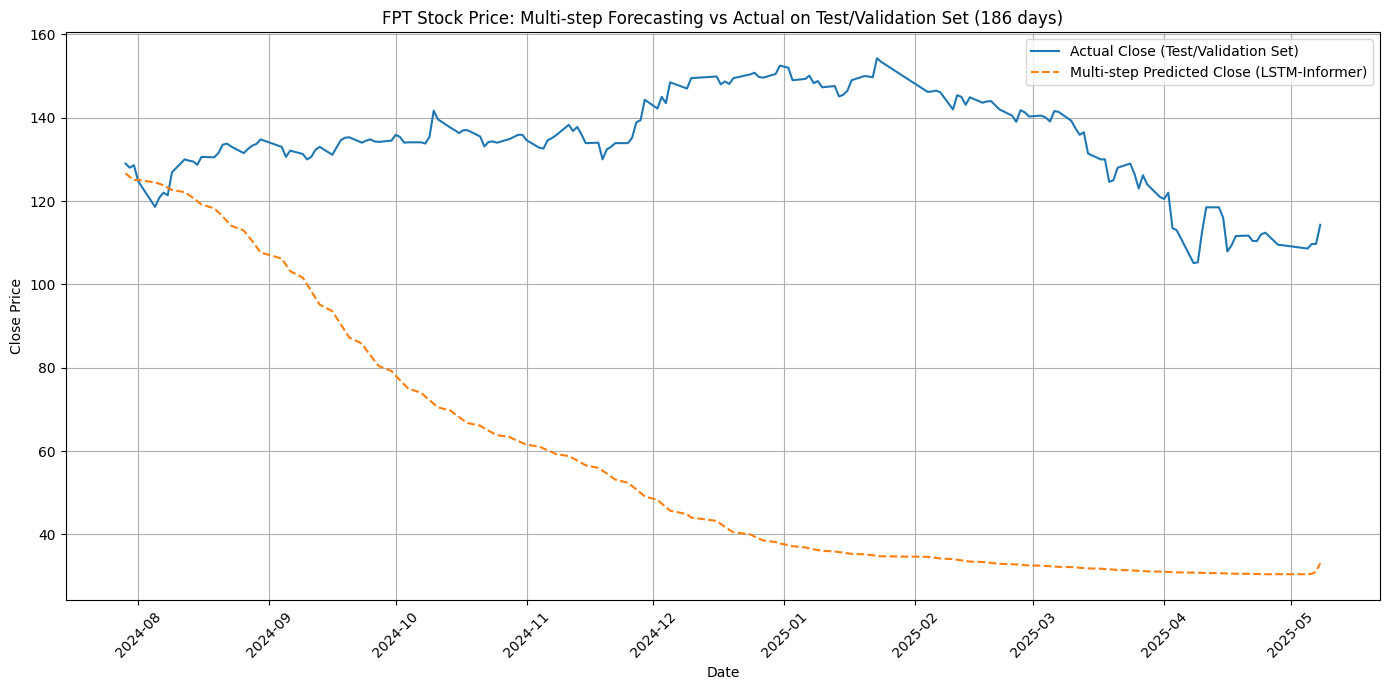

In [16]:
# Đánh giá kết quả của mô hình trên validation set với các chỉ số MAE, RMAE, R2
# Tải lại model tốt nhất đã lưu
model_lstm.load_state_dict(torch.load("best_model_lstm_5years_prophet_regressor.pth"))
model_lstm.to(device)
model_lstm.eval()

# Dữ liệu gốc chưa scale cho LSTM và Prophet
df_all_original_unscaled_eval = df_all_original_unscaled_for_lstm.copy()
# Tạo feature 'prev_close' nếu chưa có, cần cho Prophet
if regressor_name_prophet not in df_all_original_unscaled_eval.columns:
    df_all_original_unscaled_eval[regressor_name_prophet] = df_all_original_unscaled_eval['Close'].shift(1)

df_train_original_unscaled_for_multistep = df_all_original_unscaled_eval.iloc[:train_size].copy()
df_test_original_unscaled_for_multistep = df_all_original_unscaled_eval.iloc[train_size:].reset_index(drop=True)

# Số ngày cần dự đoán vào "tương lai" (chính là kích thước tập test/validation)
N_test_days_multistep = len(df_test_original_unscaled_for_multistep)

# Các giá trị 'Close' thực tế từ tập test/validation để so sánh
actual_closes_for_multistep_eval = df_test_original_unscaled_for_multistep[target_col_lstm].values
dates_for_multistep_eval = df_test_original_unscaled_for_multistep['Date'].values

multi_step_lstm_predictions_rescaled = [] # Lưu trữ giá Close dự đoán bởi LSTM cho tập test

# Khởi tạo history_df bằng toàn bộ tập train (unscaled) ban đầu.
# Chúng ta sẽ lấy sequence_length ngày cuối từ đây cho mỗi lần dự đoán.
history_df_unscaled_for_iterations = df_train_original_unscaled_for_multistep.copy()


print(f"\n--- LSTM-Informer Multi-step Forecasting Evaluation on Test/Validation Set ({N_test_days_multistep} days) ---")

if N_test_days_multistep == 0:
    print("Tập test/validation trống. Không thể thực hiện đánh giá đa bước.")
else:
    for i in range(N_test_days_multistep):
        # 1. Lấy sequence_length ngày cuối cùng từ history_df_unscaled_for_iterations cho LSTM-Informer
        current_input_sequence_unscaled_df = history_df_unscaled_for_iterations[features_lstm].iloc[-sequence_length:]

        # 2. Scale_transform các features này bằng scaler_lstm
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning) # Hoặc DataConversionWarning
            current_input_sequence_scaled = scaler_lstm.transform(current_input_sequence_unscaled_df.values)

        # 3. Dự đoán Close bằng LSTM-Informer cho ngày i của tập test
        input_tensor = torch.tensor(current_input_sequence_scaled, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            predicted_close_lstm_scaled = model_lstm(input_tensor).item()

        dummy_pred_array = np.zeros((1, len(features_lstm)))
        close_col_idx = features_lstm.index(target_col_lstm)
        dummy_pred_array[0, close_col_idx] = predicted_close_lstm_scaled
        predicted_close_lstm_rescaled = scaler_lstm.inverse_transform(dummy_pred_array)[0, close_col_idx]
        multi_step_lstm_predictions_rescaled.append(predicted_close_lstm_rescaled)

        # Nếu chưa phải là ngày cuối cùng của tập test, chuẩn bị cho lần lặp tiếp theo
        if i < N_test_days_multistep -1: # Chỉ cần cập nhật history nếu còn ngày để dự đoán
            # 4. Xác định ngày hiện tại (ngày i của tập test) mà ta vừa dự đoán 'Close'
            current_loop_date_for_prophet = dates_for_multistep_eval[i] # Ngày của dự đoán vừa thực hiện

            prev_close_for_prophet_pred = history_df_unscaled_for_iterations['Close'].iloc[-1]

            prophet_preds_values = {}
            future_df_prophet_input = pd.DataFrame({
                'ds': [current_loop_date_for_prophet], # Prophet dự đoán cho ngày i
                regressor_name_prophet: [prev_close_for_prophet_pred] # Regressor là close của ngày i-1
            })

            for feature_name, model_p_instance in prophet_models.items():
                if model_p_instance: # Chỉ Open, High, Low, Volume
                    forecast = model_p_instance.predict(future_df_prophet_input)
                    prophet_preds_values[feature_name] = forecast['yhat'].iloc[0]
                # Không cần else vì các features khác sẽ được lấy từ history hoặc tính lại

            # 6. Tạo dòng dữ liệu mới (chưa scale) để cập nhật history
            # Dòng này là cho ngày current_loop_date_for_prophet (tức là ngày i của tập test)
            new_day_data_original_dict = {
                'Date': current_loop_date_for_prophet,
                'Close': predicted_close_lstm_rescaled, # Close dự đoán từ LSTM cho ngày i
                'Open': prophet_preds_values.get('Open', predicted_close_lstm_rescaled),
                'High': prophet_preds_values.get('High', predicted_close_lstm_rescaled),
                'Low': prophet_preds_values.get('Low', predicted_close_lstm_rescaled),
                'Volume': prophet_preds_values.get('Volume', history_df_unscaled_for_iterations['Volume'].iloc[-1]),
                # Giữ nguyên NetForeign... từ ngày cuối của history cũ (đơn giản hóa)
                'NetForeignVolume': history_df_unscaled_for_iterations['NetForeignVolume'].iloc[-1],
                'NetForeignValue': history_df_unscaled_for_iterations['NetForeignValue'].iloc[-1],
            }

            # Áp dụng logic ràng buộc O-H-L-C
            cl = new_day_data_original_dict['Close']
            op = new_day_data_original_dict['Open']
            lo = new_day_data_original_dict['Low']
            hi = new_day_data_original_dict['High']

            new_day_data_original_dict['Low'] = min(lo, op, cl) if op is not None and cl is not None else lo # Low phải là thấp nhất của O, C, Low_pred
            new_day_data_original_dict['High'] = max(hi, op, cl) if op is not None and cl is not None else hi # High phải là cao nhất của O, C, High_pred
            # Đảm bảo Open nằm giữa Low và High
            new_day_data_original_dict['Open'] = max(new_day_data_original_dict['Low'], min(op, new_day_data_original_dict['High'])) if op is not None else op
            new_day_data_original_dict['Volume'] = max(0, new_day_data_original_dict.get('Volume',0))


            for col_ti in ti_cols_to_drop:
                new_day_data_original_dict[col_ti] = np.nan # Để tính lại

            new_day_df_unscaled = pd.DataFrame([new_day_data_original_dict])

            # 8. Nối dòng mới và tính lại chỉ báo kỹ thuật
            # Thêm dòng dữ liệu *dự đoán* của ngày i vào history
            history_df_unscaled_for_iterations = pd.concat([history_df_unscaled_for_iterations, new_day_df_unscaled], ignore_index=True)
            # Xóa các cột TI cũ trước khi gọi add_technical_indicators
            temp_history_for_ti_recalc = history_df_unscaled_for_iterations.drop(columns=ti_cols_to_drop, errors='ignore')
            history_df_unscaled_for_iterations = add_technical_indicators(temp_history_for_ti_recalc)

            # Cập nhật 'prev_close' cho Prophet trong history (cho ngày cuối cùng vừa thêm)
            if regressor_name_prophet in history_df_unscaled_for_iterations.columns:
                if len(history_df_unscaled_for_iterations) > 1:
                    history_df_unscaled_for_iterations.loc[history_df_unscaled_for_iterations.index[-1], regressor_name_prophet] = history_df_unscaled_for_iterations['Close'].iloc[-2]
                else:
                    history_df_unscaled_for_iterations.loc[history_df_unscaled_for_iterations.index[-1], regressor_name_prophet] = np.nan


    # Tính toán các chỉ số
    mae_multistep = mean_absolute_error(actual_closes_for_multistep_eval, multi_step_lstm_predictions_rescaled)
    rmse_multistep = np.sqrt(mean_squared_error(actual_closes_for_multistep_eval, multi_step_lstm_predictions_rescaled))
    r2_multistep = r2_score(actual_closes_for_multistep_eval, multi_step_lstm_predictions_rescaled)

    print(f"\n--- LSTM-Informer Multi-step Forecasting Evaluation (on Test/Validation set) ---")
    print(f"MAE (multi-step): {mae_multistep:.4f}")
    print(f"RMSE (multi-step): {rmse_multistep:.4f}")
    print(f"R2 Score (multi-step): {r2_multistep:.4f}")

    # Vẽ đồ thị so sánh
    plt.figure(figsize=(14, 7))
    plt.plot(dates_for_multistep_eval, actual_closes_for_multistep_eval, label='Actual Close (Test/Validation Set)')
    plt.plot(dates_for_multistep_eval, multi_step_lstm_predictions_rescaled, label=f'Multi-step Predicted Close (LSTM-Informer)', linestyle='--')
    plt.title(f'FPT Stock Price: Multi-step Forecasting vs Actual on Test/Validation Set ({N_test_days_multistep} days)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()